In [96]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
def dateDiff(date1, date2):
    if date1 > date2:
        difDays = datetime.datetime.strptime(date1, "%Y-%m-%d") - datetime.datetime.strptime(date2, "%Y-%m-%d")
    else:
        difDays = datetime.datetime.strptime(date2, "%Y-%m-%d") - datetime.datetime.strptime(date1, "%Y-%m-%d")
    return difDays.days

In [229]:
def monthDiff(date1, date2):
    date1 = datetime.datetime.strptime(date1, "%Y-%m-%d") 
    date2 = datetime.datetime.strptime(date2, "%Y-%m")
    months = (date1.year - date2.year) * 12 + date1.month - date2.month
    return months

In [285]:
BASE_PATH = "~/Downloads/kaggle/paipaidai/data/"
raw_train_data = pd.read_csv(BASE_PATH + "train.csv", na_values="\\N")
raw_test_data = pd.read_csv(BASE_PATH + "test.csv", na_values="\\N")

In [286]:
raw_train_data.shape, raw_test_data.shape

((1000000, 7), (130000, 5))

In [17]:
raw_train_data['repay_amt'].isnull().sum()

117192

In [289]:
sub_train_data = raw_train_data[~ raw_train_data.repay_date.isnull()]

In [292]:
sub_train_data[sub_train_data.due_amt != sub_train_data.repay_amt]

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt


In [66]:
sub_train_data['diff_date'] = sub_train_data.apply(lambda row:dateDiff(row['due_date'], row['repay_date']), axis=1)
sub_train_data['diff_amt'] = sub_train_data.apply(lambda row:row['repay_amt'] - row['due_amt'], axis=1)

/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
def audit_order(sub_train_data):
    sub_train_data = sub_train_data.sort_values(['user_id', 'listing_id'])
    sub_train_data['group_rank'] = sub_train_data[["user_id", "listing_id"]].groupby(["user_id"]).rank(method="min")
    return sub_train_data

In [193]:
test_min = test_data.listing_id.min()
train_max = sub_train_data.listing_id.max()
data = pd.concat([sub_train_data[list(test_data.columns)], test_data])
new_data = audit_order(data)
new_data.shape

(1012808, 6)

In [233]:
train_max, test_min

(5207722, 5282923)

In [194]:
listing_info = pd.read_csv(BASE_PATH + "listing_info.csv", na_values="\\N")
new_data = new_data.merge(listing_info, on=['user_id', 'listing_id', 'auditing_date'], how="inner")
new_data.shape

(1012808, 9)

In [196]:
user_info = pd.read_csv(BASE_PATH + "user_info.csv", na_values="\\N")
new_data = new_data.merge(user_info, on=["user_id"], how="left")

# 过滤数据用
new_data['diff_days'] = new_data.apply(lambda row: dateDiff(row['auditing_date'], row['insertdate']), axis=1)
new_data['diff_min'] = new_data.groupby("listing_id")['diff_days'].transform("min")

new_data = new_data[(new_data['diff_days'] == new_data['diff_min'])].sort_values(['listing_id', 'insertdate']).drop_duplicates("listing_id")
new_data.shape

In [293]:
new_data.head()

,user_id,listing_id,auditing_date,due_date,due_amt,group_rank,term,rate,principal,reg_mon,gender,age,cell_province,id_province,id_city,insertdate,diff_days,diff_min,use_month
507476,438081,1873193,2018-01-01,2018-02-01,97.3003,1.0,9,7.2,850,2017-03,女,34,c28,c28,c28005,2017-12-31,1,1,10
790711,679097,1873199,2018-01-01,2018-02-01,200.8172,1.0,6,7.2,1180,2017-10,男,23,c04,c25,c25121,2017-12-31,1,1,3
579416,498924,1873205,2018-01-01,2018-02-01,226.6526,1.0,9,7.2,1980,2017-05,女,26,c06,c06,c06266,2017-12-31,1,1,8
394198,342463,1873207,2018-01-01,2018-02-01,125.9181,1.0,9,7.2,1100,2016-12,男,22,c31,c31,c31255,2017-12-31,1,1,13
341889,297792,1873212,2018-01-01,2018-02-01,163.3767,1.0,6,7.2,960,2016-10,女,28,c27,c27,c27330,2017-12-31,1,1,15


In [230]:
# 用户注册时间和成交时间相隔月数
new_data['use_month'] = new_data.apply(lambda row:monthDiff(row['auditing_date'], row['reg_mon']), axis=1)

In [245]:
# 用户画像数据
user_taglist = pd.read_csv(BASE_PATH + "user_taglist.csv", na_values="\\N")
new_data = new_data.merge(listing_info, on=['user_id', 'listing_id', 'auditing_date'], how="inner")

In [278]:
# 用户还款日志表
user_repay_logs = pd.read_csv(BASE_PATH + "user_repay_logs.csv", na_values="\\N")
user_repay_logs.rename(columns={'due_date':'order_due_date', 
                                'due_amt':'order_due_amt', 
                                'repay_date':'order_repay_date', 
                                'repay_amt':'order_repay_amt'}, inplace=True)

In [308]:
new_data.groupby("user_id").agg({"listing_id":"nunique"}).sort_values("listing_id", ascending=False).head()

,listing_id
user_id,
893965,13
783346,11
79343,11
832234,9
839840,9


In [310]:
new_data[new_data.user_id == 893965]

,user_id,listing_id,auditing_date,due_date,due_amt,group_rank,term,rate,principal,reg_mon,gender,age,cell_province,id_province,id_city,insertdate,diff_days,diff_min,use_month
1034729,893965,4415144,2018-09-11,2018-10-11,199.7496,1.0,6,8.3,1170,2018-08,男,39,c04,c11,c11159,2018-09-10,1,1,1
1034730,893965,4594544,2018-10-05,2018-11-05,199.7496,2.0,6,8.3,1170,2018-08,男,39,c04,c11,c11159,2018-09-10,25,25,2
1034731,893965,4736983,2018-10-24,2018-11-24,199.3462,3.0,6,7.6,1170,2018-08,男,39,c04,c11,c11159,2018-09-10,44,44,2
1034732,893965,4738042,2018-10-24,2018-11-24,199.3462,4.0,6,7.6,1170,2018-08,男,39,c04,c11,c11159,2018-09-10,44,44,2
1034733,893965,4741455,2018-10-24,2018-11-24,107.3402,5.0,6,7.6,630,2018-08,男,39,c04,c11,c11159,2018-09-10,44,44,2
1034734,893965,4759291,2018-10-26,2018-11-26,199.3462,6.0,6,7.6,1170,2018-08,男,39,c04,c11,c11159,2018-09-10,46,46,2
1034735,893965,4948209,2018-11-20,2018-12-20,197.2230,7.0,12,8.6,2260,2018-08,男,39,c04,c11,c11159,2018-09-10,71,71,3
1034736,893965,4960510,2018-11-22,2018-12-22,197.2230,8.0,12,8.6,2260,2018-08,男,39,c04,c11,c11159,2018-09-10,73,73,3
1034737,893965,4981184,2018-11-25,2018-12-25,197.2230,9.0,12,8.6,2260,2018-08,男,39,c04,c11,c11159,2018-09-10,76,76,3
1034738,893965,4981459,2018-11-25,2018-12-25,197.2230,10.0,12,8.6,2260,2018-08,男,39,c04,c11,c11159,2018-09-10,76,76,3


In [304]:
a = new_data.merge(user_repay_logs[['listing_id', 'order_id', 'order_due_date', 'order_due_amt', 'order_repay_date', 'order_repay_amt']], on="listing_id", how="inner")

In [312]:
a[a.user_id == 893965].sort_values(["listing_id", "order_id"])

,user_id,listing_id,auditing_date,due_date,due_amt,group_rank,term,rate,principal,reg_mon,...,id_city,insertdate,diff_days,diff_min,use_month,order_id,order_due_date,order_due_amt,order_repay_date,order_repay_amt
589400,893965,4415144,2018-09-11,2018-10-11,199.7496,1.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,1,1,1,1,2018-10-11,199.7496,2018-09-24,199.7496
589404,893965,4415144,2018-09-11,2018-10-11,199.7496,1.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,1,1,1,2,2018-11-11,199.7496,2018-09-24,199.7496
589399,893965,4415144,2018-09-11,2018-10-11,199.7496,1.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,1,1,1,3,2018-12-11,199.7496,2018-09-24,199.7496
589402,893965,4415144,2018-09-11,2018-10-11,199.7496,1.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,1,1,1,4,2019-01-11,199.7496,2018-09-24,199.7496
589403,893965,4415144,2018-09-11,2018-10-11,199.7496,1.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,1,1,1,5,2019-02-11,199.7496,2018-09-24,199.7496
589401,893965,4415144,2018-09-11,2018-10-11,199.7496,1.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,1,1,1,6,2019-03-11,199.7496,2018-09-24,199.7496
613280,893965,4594544,2018-10-05,2018-11-05,199.7496,2.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,25,25,2,1,2018-11-05,199.7496,2018-10-16,199.7496
613281,893965,4594544,2018-10-05,2018-11-05,199.7496,2.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,25,25,2,2,2018-12-05,199.7496,2018-10-17,199.7496
613283,893965,4594544,2018-10-05,2018-11-05,199.7496,2.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,25,25,2,3,2019-01-05,199.7496,2018-10-20,199.7496
613282,893965,4594544,2018-10-05,2018-11-05,199.7496,2.0,6,8.3,1170,2018-08,...,c11159,2018-09-10,25,25,2,4,2019-02-05,199.7496,2018-10-20,199.7496


In [297]:
new_data[new_data.user_id == 1]

,user_id,listing_id,auditing_date,due_date,due_amt,group_rank,term,rate,principal,reg_mon,gender,age,cell_province,id_province,id_city,insertdate,diff_days,diff_min,use_month
0,1,5138741,2018-12-17,2019-01-17,634.1695,1.0,9,7.2,5540,2008-03,男,35,c22,c31,c31067,2018-12-16,1,1,129


In [298]:
user_repay_logs[user_repay_logs.user_id == 1]

,user_id,listing_id,order_id,order_due_date,order_due_amt,order_repay_date,order_repay_amt
9204193,1,445999,12,2018-06-21,120.8751,2018-02-15,120.8751


In [284]:
user_repay_logs.sort_values(["user_id", "listing_id"])

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt
9204193,1,445999,12,2018-06-21,120.8751,2018-02-15,120.8751
3808131,2,1655550,11,2018-11-06,243.5698,2018-01-04,243.5698
3808132,2,1655550,12,2018-12-06,243.5698,2018-01-04,243.5698
3808133,2,1655550,5,2018-05-06,243.5698,2018-01-04,243.5698
3808134,2,1655550,6,2018-06-06,243.5698,2018-01-04,243.5698
3808135,2,1655550,7,2018-07-06,243.5698,2018-01-04,243.5698
3808136,2,1655550,8,2018-08-06,243.5698,2018-01-04,243.5698
3808137,2,1655550,9,2018-09-06,243.5698,2018-01-04,243.5698
3808138,2,1655550,10,2018-10-06,243.5698,2018-01-04,243.5698
16342323,3,806012,5,2018-01-19,853.1329,2018-01-18,853.1329


In [232]:
category_columns = ['gender', 'cell_province', 'id_province', 'id_city']
continus_columns = ['due_amt', 'group_rank', 'term', 'rate', 'principal', 'age', 'use_month']

In [234]:
train_data = new_data[new_data.listing_id < 5282923]
test_data = new_data[new_data.listing_id >= 5282923]
for f in category_columns:
    train_data[f], indexer = pd.factorize(train_data[f], sort=True)
    test_data[f] = indexer.get_indexer(test_data[f])

/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [235]:
features = category_columns + continus_columns

In [244]:
train_data = train_data.merge(sub_train_data[['listing_id', 'diff_date', 'diff_amt']], on="listing_id", how="left")

/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  0 :
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 50.7355	training's l1: 4.88785	valid_1's l2: 50.3732	valid_1's l1: 4.87297
[100]	training's l2: 50.4708	training's l1: 4.87041	valid_1's l2: 50.2795	valid_1's l1: 4.86283
[150]	training's l2: 50.2803	training's l1: 4.86021	valid_1's l2: 50.2594	valid_1's l1: 4.86015
[200]	training's l2: 50.1241	training's l1: 4.85237	valid_1's l2: 50.2581	valid_1's l1: 4.85925
[250]	training's l2: 49.9816	training's l1: 4.84502	valid_1's l2: 50.2529	valid_1's l1: 4.85824
[300]	training's l2: 49.843	training's l1: 4.83832	valid_1's l2: 50.254	valid_1's l1: 4.85785
Early stopping, best iteration is:
[271]	training's l2: 49.9274	training's l1: 4.84234	valid_1's l2: 50.2526	valid_1's l1: 4.85811


/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  1 :
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 50.4179	training's l1: 4.86459	valid_1's l2: 50.9771	valid_1's l1: 4.89112
[100]	training's l2: 50.1458	training's l1: 4.84634	valid_1's l2: 50.8936	valid_1's l1: 4.88106
[150]	training's l2: 49.9682	training's l1: 4.83683	valid_1's l2: 50.8829	valid_1's l1: 4.87907
[200]	training's l2: 49.7984	training's l1: 4.82835	valid_1's l2: 50.8842	valid_1's l1: 4.87812
Early stopping, best iteration is:
[156]	training's l2: 49.9499	training's l1: 4.83579	valid_1's l2: 50.8809	valid_1's l1: 4.8787


/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  2 :
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 50.4934	training's l1: 4.87551	valid_1's l2: 50.8469	valid_1's l1: 4.88713
[100]	training's l2: 50.2323	training's l1: 4.85769	valid_1's l2: 50.7549	valid_1's l1: 4.87727
[150]	training's l2: 50.0547	training's l1: 4.84821	valid_1's l2: 50.7471	valid_1's l1: 4.87559
[200]	training's l2: 49.8897	training's l1: 4.83985	valid_1's l2: 50.7467	valid_1's l1: 4.87474
Early stopping, best iteration is:
[156]	training's l2: 50.0352	training's l1: 4.84713	valid_1's l2: 50.7465	valid_1's l1: 4.87536


/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


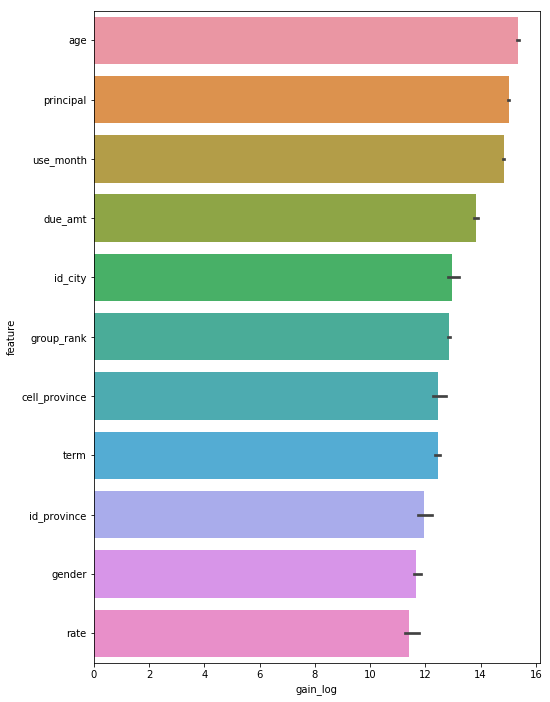

In [258]:
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import seaborn as sns

n_splits = 3
folds = KFold(n_splits=n_splits, shuffle=True, random_state=123)

clf = lgb.LGBMRegressor(
    learning_rate=0.1,
    num_leaves=31,
    objective='regression',
    min_data_in_leaf=30,
    n_estimators=1000,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda= 1e-5,
    random_state=2019
)

# train_data = data2.sample(frac = 0.7)
# test_idx = data2.index.difference(train_data.index)
# test_data = data2.iloc[test_idx]

target = "diff_date"
features = features

importances = pd.DataFrame()
test_data['pred'] = 0
train_data['pred'] = 0
for fold_id, (trn, val) in enumerate(folds.split(train_data)):

    devel = train_data[features].iloc[trn]
    y_devel = train_data[target].iloc[trn]
    valid = train_data[features].iloc[val]
    y_valid = train_data[target].iloc[val]

    print("Fold ", fold_id, ":")

    clf.fit(devel, y_devel, eval_set=[(devel, y_devel), (valid, y_valid)],
            early_stopping_rounds=50, verbose=50, eval_metric='l1')

    imp_df = pd.DataFrame()
    imp_df["feature"] = features
    try:
        imp_df["gain"] = clf.booster_.feature_importance(
            importance_type='gain')
        
    except:
        imp_df["gain"] = clf.feature_importances_

    imp_df['fold'] = fold_id + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    predictions = clf.predict(valid)

    test_data['pred'] += clf.predict(test_data[features])/n_splits
    train_data['pred'] += clf.predict(train_data[features])/n_splits
#     print("Fold ", fold_id, " auc score: ",roc_auc_score(y_valid, predictions))

warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature',
            data=importances.sort_values('mean_gain', ascending=False))

In [268]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

def score(data, y, target, data_id):
    validation_res = pd.DataFrame(
    { data_id: data[data_id].values,
      target: data[target].values,
     "prediction": y})

    validation_res = validation_res.groupby(data_id)[target, "prediction"].sum().reset_index()
    return np.sqrt(mean_squared_error(validation_res[target].values, 
                                     validation_res["prediction"].values))
class KFoldValidation():
    def __init__(self, data, rank_idx, n_splits=5):
        self.rank_idx = rank_idx
        unique_vis = np.array(sorted(data[rank_idx].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data[rank_idx].astype(str).isin(unique_vis[trn_vis])],
                    ids[data[rank_idx].astype(str).isin(unique_vis[val_vis])]])
            
    def validate(self, train, test, features, model, target = "totals_transactionRevenue", name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        importances = pd.DataFrame()
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = train[target].iloc[trn]
            valid = train[features].iloc[val]
            y_valid = train[target].iloc[val]
                       
            print("Fold ", fold_id, ":")
                     
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            imp_df = pd.DataFrame()
            
#             if len(model.feature_importances_) == len(features):  # some bugs in catboost?
#                 imp_df['feature'] = features
#                 imp_df['gain'] = model.booster_.feature_importance(importance_type='gain')

#                 imp_df['fold'] = fold_id + 1
#                 importances = pd.concat([importances, imp_df], axis=0, sort=False)
#                 model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            imp_df = pd.DataFrame()
            imp_df["feature"] = features
            try:
                imp_df["gain"] = clf.booster_.feature_importance(
                    importance_type='gain')

            except:
                imp_df["gain"] = clf.feature_importances_

            imp_df['fold'] = fold_id + 1
            importances = pd.concat([importances, imp_df], axis=0, sort=False)

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions, target, self.rank_idx)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        warnings.simplefilter('ignore', FutureWarning)
        importances['gain_log'] = np.log1p(importances['gain'])
        mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
        importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

        plt.figure(figsize=(8, 12))
        sns.barplot(x='gain_log', y='feature',
                    data=importances.sort_values('mean_gain', ascending=False))   
        return full_score

/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 7.08536
[200]	valid_0's rmse: 7.08338
[300]	valid_0's rmse: 7.0832
Early stopping, best iteration is:
[279]	valid_0's rmse: 7.08299
Fold  0  error:  7.082987210967108
Fold  0  score:  7.082987210967108


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 7.13807
[200]	valid_0's rmse: 7.13561
Early stopping, best iteration is:
[190]	valid_0's rmse: 7.13546
Fold  1  error:  7.135458088153348
Fold  1  score:  7.135458088153348


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 7.11467
[200]	valid_0's rmse: 7.11266
Early stopping, best iteration is:
[229]	valid_0's rmse: 7.11253
Fold  2  error:  7.112533765436593
Fold  2  score:  7.112533765436593


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  3 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 7.13757
[200]	valid_0's rmse: 7.13704
Early stopping, best iteration is:
[195]	valid_0's rmse: 7.13697
Fold  3  error:  7.1369662879103775
Fold  3  score:  7.1369662879103775


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  4 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 7.10259
[200]	valid_0's rmse: 7.10138
Early stopping, best iteration is:
[214]	valid_0's rmse: 7.10128
Fold  4  error:  7.101280338721233
Fold  4  score:  7.101280338721233


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Final score:  7.113845138237731


7.113845138237731

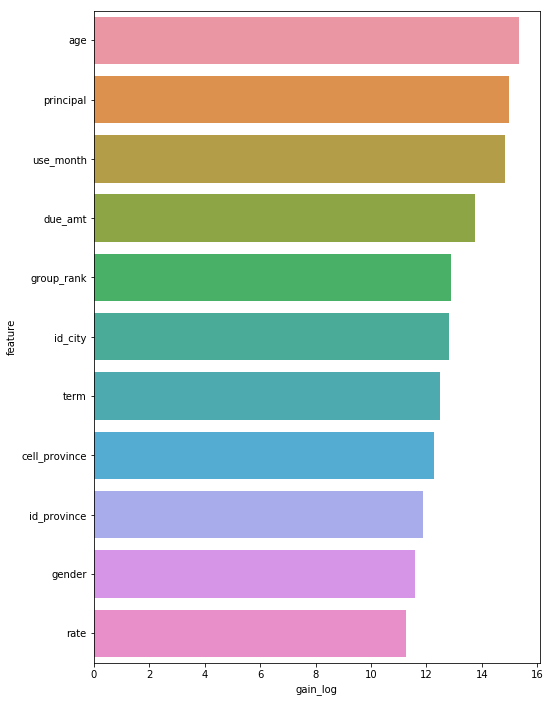

In [270]:
Kfolder = KFoldValidation(train_data, "listing_id")

lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.1, bagging_fraction=0.7, feature_fraction=0.8, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)
Kfolder.validate(train_data, test_data, features, lgbmodel, "diff_date", "diff_date_pred", prepare_stacking=True)


/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  0 :
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0
Fold  0  error:  0.0
Fold  0  score:  0.0


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  1 :
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0
Fold  1  error:  0.0
Fold  1  score:  0.0


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  2 :
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0
Fold  2  error:  0.0
Fold  2  score:  0.0


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  3 :
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0
Fold  3  error:  0.0
Fold  3  score:  0.0


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold  4 :
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0
Fold  4  error:  0.0
Fold  4  score:  0.0


/Users/lkjin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lkjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Final score:  0.0


0.0

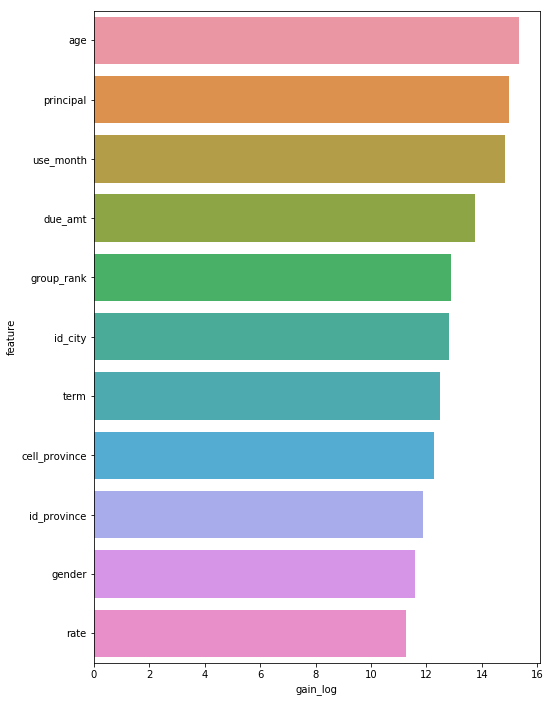

In [274]:
Kfolder.validate(train_data, test_data, features, lgbmodel, "diff_amt", "diff_amt_pred", prepare_stacking=True)